In [71]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext autoreload
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import sys
from ipywidgets import interactive, FloatSlider, interact, fixed
from divtel import *
from adjustText import adjust_text

import copy
import astropy.units as u
from astropy.coordinates import SkyCoord

from astroplan.plots import plot_sky
from astroplan import FixedTarget
#from . import utils
#from .const import COLORS
#from . import pointing

from matplotlib.transforms import Affine2D
from astropy.visualization.wcsaxes import SphericalCircle

import healpy as hp
import tqdm

#!jupyter labextension install @jupyter-widgets/jupyterlab-manager

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## LOAD CTA CONFIG

In [4]:
cta = CTA_Info('south')

Observer         :  CTA South
Location         :  Paranal , (1946.635798, -5467.63394562, -2642.49852123) km
Observation time :  2025-02-15T22:50:13.498


In [5]:
array_MST = LoadConfig("/Users/macbook/divtel/Paranal_Only_MST.txt", frame=cta)

In [6]:

array_SST = LoadConfig("/Users/macbook/divtel/Paranal_Only_SST.txt", frame=cta)

In [7]:
array_MST.table.units = "deg"
array_MST.table
array_SST.table.units ="deg"

In [8]:
def compute_center_of_gravity(group):
    x, y, z = group['x'], group['y'], group['z']
    cog_x = round(np.mean(x),2)
    cog_y = round(np.mean(y),2)
    cog_z = round(np.mean(z),2)
    return cog_x, cog_y, cog_z

# Function to create new telescope list with center of gravity
def create_new_group_list(tel_group):
    new_telescopes = []
    for group in tel_group.groups:
        print(tel_group.groups)
        print (group['focal'][0],round(group['radius'][0],2))
        #id_ = group["id"][0]
        cog = compute_center_of_gravity(group)
        focal, fov = group['focal'][0], round(group['radius'][0],2)  # Assuming same within a group
        new_telescopes.append([*cog, focal, fov])
    return new_telescopes


In [9]:
array_MST.table

id,x,y,z,az,alt,zn,focal,radius,fov,p_x,p_y,p_z,d_tel
,m,m,m,deg,deg,deg,m,deg,deg2,,,,m
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,0.0,0.0,24.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,22.65
2,0.0,151.0,25.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,152.67
3,0.0,-151.0,31.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,152.68
4,150.0,75.0,21.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,188.09
5,150.0,-75.0,26.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,187.98
6,150.0,240.0,24.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,295.50
7,150.0,-240.0,30.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,295.49
8,313.0,0.0,19.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,335.47


In [10]:
array_SST.table

id,x,y,z,az,alt,zn,focal,radius,fov,p_x,p_y,p_z,d_tel
,m,m,m,deg,deg,deg,m,deg,deg2,,,,m
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,199.0,0.0,16.25,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,200.19
2,-230.0,0.0,22.75,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,229.36
3,-249.0,-325.0,40.75,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,409.12
4,-249.0,325.0,17.25,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,409.16
5,-249.0,-577.0,54.25,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,628.62
6,-249.0,577.0,8.25,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,628.51
7,-220.0,-797.0,68.25,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,827.51
8,-220.0,797.0,10.25,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,826.84


## Choosing the different configurations

In [11]:
sub_groups_MST={'1':[3,4,7], 
            '2': [1,9,12,14],
            '3': [10,11,13], 
             '4': [2,6,8,5]}
sub_groups_SST = {'1':[24,12,30,42,8,18], 
             '2':[44,32,34],
              '3':[43,33,35],
              '4':[23,41,29,11,7,17],
              '5':[37,39,45],
              '6':[38,40,46],
              '7':[1,2,9,10],
              '8':[16,26,28],
              '9':[15,25,27],
              '10':[13,14,36],
              '11':[5,19,21],
              '12':[6,20,22],
              '13':[3,4,31]}



In [12]:
tel_group, labels, number_of_telescopes_subarray_1 =array_MST.group_by(sub_groups_MST)

In [13]:
tel_group_SST, labels_SST, number_of_telescopes_config_SST =array_SST.group_by(sub_groups_SST)

In [14]:
new_telescopes = create_new_group_list(tel_group)

<TableGroups indices=[ 0  3  7 10 14]>
16.0 3.85
<TableGroups indices=[ 0  3  7 10 14]>
16.0 3.85
<TableGroups indices=[ 0  3  7 10 14]>
16.0 3.85
<TableGroups indices=[ 0  3  7 10 14]>
16.0 3.85


In [15]:
new_telescopes_SST = create_new_group_list(tel_group_SST)

<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45


In [16]:
for telescope in new_telescopes:
    print(telescope)

[100.0, -105.33, 27.33, 16.0, 3.85]
[-153.25, 81.75, 27.38, 16.0, 3.85]
[-204.33, -109.0, 33.83, 16.0, 3.85]
[153.25, 79.0, 23.5, 16.0, 3.85]


In [17]:
for telescope in new_telescopes_SST:
    print(telescope)

[0.0, 816.83, 21.83, 5.6, 4.45]
[-840.0, 404.67, 16.75, 5.6, 4.45]
[-840.0, -404.67, 55.92, 5.6, 4.45]
[0.0, -816.83, 65.42, 5.6, 4.45]
[839.67, -404.67, 17.75, 5.6, 4.45]
[839.67, 404.67, 10.08, 5.6, 4.45]
[-7.75, 0.0, 22.5, 5.6, 4.45]
[415.67, 402.0, 12.42, 5.6, 4.45]
[415.67, -402.0, 27.92, 5.6, 4.45]
[429.33, 0.0, 16.08, 5.6, 4.45]
[-415.67, -402.0, 48.25, 5.6, 4.45]
[-415.67, 402.0, 15.58, 5.6, 4.45]
[-429.67, 0.0, 29.42, 5.6, 4.45]


In [18]:
# Define the file path where you want to save the output
output_file_path = './best_configuration_MST.txt'

# Open the file in write mode
with open(output_file_path, 'w') as file:
    
    # Write a header
    #file.write("Group ID, X_Center, Y_Center, Z_Center, Focal Length, FOV\n")
    
    # Loop through all new telescopes (grouped telescopes)
    for i, telescope in enumerate(new_telescopes):
        # Assuming telescope is a list like [x_center, y_center, z_center, focal_length, fov]
        values = ' '.join(map(str, telescope))  # Convert all elements to string
        # Write the data to the file
        #print(values)
        file.write(f"{values}\n")

print(f"New telescope data has been written to {output_file_path}")


New telescope data has been written to ./best_configuration_MST.txt


In [19]:
# Define the file path where you want to save the output
output_file_path = './best_configuration_SST.txt'

# Open the file in write mode
with open(output_file_path, 'w') as file:
    
    # Write a header
    #file.write("Group ID, X_Center, Y_Center, Z_Center, Focal Length, FOV\n")
    
    # Loop through all new telescopes (grouped telescopes)
    for i, telescope in enumerate(new_telescopes_SST):
        # Assuming telescope is a list like [x_center, y_center, z_center, focal_length, fov]
        values = ' '.join(map(str, telescope))  # Convert all elements to string
        # Write the data to the file
        #print(values)
        file.write(f"{values}\n")

print(f"New telescope data has been written to {output_file_path}")


New telescope data has been written to ./best_configuration_SST.txt


In [46]:
config_MST = LoadConfig("/Users/macbook/divtel/best_configuration_MST.txt", frame=cta)
config_SST = LoadConfig("/Users/macbook/divtel/best_configuration_SST.txt", frame=cta)
full_array_config_SST = LoadConfig("/Users/macbook/divtel/best_configuration_SST.txt", frame=cta)

In [21]:
config_MST.table.units= "deg"

In [22]:
config_MST.table

id,x,y,z,az,alt,zn,focal,radius,fov,p_x,p_y,p_z,d_tel
,m,m,m,deg,deg,deg,m,deg,deg2,,,,m
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,100.0,-105.33,27.33,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,156.04
2,-153.25,81.75,27.38,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,158.82
3,-204.33,-109.0,33.83,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,202.35
4,153.25,79.0,23.5,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,201.79


In [23]:
config_SST.table.units = "deg"

In [24]:
config_SST.table

id,x,y,z,az,alt,zn,focal,radius,fov,p_x,p_y,p_z,d_tel
,m,m,m,deg,deg,deg,m,deg,deg2,,,,m
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,0.0,816.83,21.83,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,816.85
2,-840.0,404.67,16.75,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,931.85
3,-840.0,-404.67,55.92,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,932.21
4,0.0,-816.83,65.42,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,817.70
5,839.67,-404.67,17.75,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,932.76
6,839.67,404.67,10.08,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,932.87
7,-7.75,0.0,22.5,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,8.77
8,415.67,402.0,12.42,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,578.95


In [73]:
div_stop=[]

div_stop=np.linspace(0,0.03, 10)


In [74]:
FoV_array_MST=[]#This will be the one without saturation
multiplicity_array_MST=[] #This will be the one without saturation

for div in div_stop:
    config_MST.divergent_pointing(div, az=0,alt=70)    
    FoV_array_MST=config_MST.hFoV(subarray_mult=number_of_telescopes_subarray_1)[0]
    multiplicity_array_MST=config_MST.hFoV(subarray_mult=number_of_telescopes_subarray_1)[1]



4it [00:00,  6.50it/s]
4it [00:00,  6.76it/s]
4it [00:00,  6.85it/s]
4it [00:00,  6.05it/s]
4it [00:00,  5.73it/s]
4it [00:00,  6.88it/s]
4it [00:00,  6.68it/s]
4it [00:00,  6.88it/s]
4it [00:00,  6.27it/s]
4it [00:00,  6.71it/s]
4it [00:00,  6.65it/s]
4it [00:00,  6.92it/s]
4it [00:00,  6.89it/s]
4it [00:00,  6.00it/s]
4it [00:00,  6.46it/s]
4it [00:00,  6.09it/s]
4it [00:00,  6.13it/s]
4it [00:00,  5.87it/s]
4it [00:00,  5.95it/s]
4it [00:00,  5.76it/s]


In [27]:
FoV_array_SST=[]#This will be the one without saturation
multiplicity_array_SST=[] #This will be the one without saturation

for div in div_stop:
    config_SST.divergent_pointing(div, az=0,alt=70)    
    FoV_array_SST=config_SST.hFoV(subarray_mult=number_of_telescopes_config_SST)[0]
    multiplicity_array_SST=config_SST.hFoV(subarray_mult=number_of_telescopes_config_SST)[1]


13it [00:01,  7.37it/s]
13it [00:01,  7.07it/s]
13it [00:01,  6.91it/s]
13it [00:01,  6.82it/s]
13it [00:01,  6.94it/s]
13it [00:01,  6.85it/s]
13it [00:01,  7.02it/s]
13it [00:01,  6.88it/s]
13it [00:01,  6.60it/s]
13it [00:01,  6.78it/s]
13it [00:01,  7.03it/s]
13it [00:01,  6.91it/s]
13it [00:01,  6.87it/s]
13it [00:01,  6.66it/s]
13it [00:01,  6.93it/s]
13it [00:01,  6.92it/s]
13it [00:01,  7.09it/s]
13it [00:01,  7.08it/s]
13it [00:01,  7.17it/s]
13it [00:01,  7.18it/s]


4it [00:00,  7.05it/s]
4it [00:00,  6.68it/s]


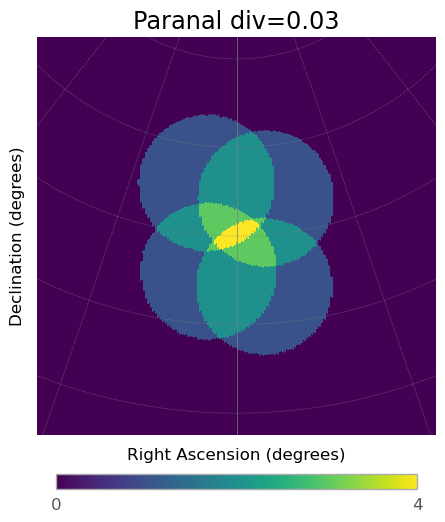

In [28]:
config_MST.multiplicity_plot()

In [31]:
table_SST_conv = []
table_SST= config_SST.table
number_of_telescopes_config_SST_first_half=[]
# Append the columns for LST so I know what to get or expect
table_SST_conv.append(table_SST['x'])
table_SST_conv.append(table_SST['y'])
table_SST_conv.append(table_SST['z'])
table_SST_conv.append(table_SST['focal'])
table_SST_conv.append(table_SST['radius'])
table_SST_conv.append(table_SST['fov'])

# Initialize sub_config and other variables
sub_config = []
telescopes = [1, 2,3,4,5,6]  # Telescope indices
# Loop through the telescopes so I can write them in a file
for tel in telescopes:
    # Putting it tel-1 because the first column we had the index
    sub_config.append([col[tel - 1] for col in table_SST_conv])
    number_of_telescopes_config_SST_first_half.append(number_of_telescopes_config_SST[tel-1])


# Print the result for verification
print(sub_config)
print(number_of_telescopes_config_SST_first_half)

[[0.0, 816.83, 21.83, 5.6, 4.450000000000001, 62.46242685852285], [-840.0, 404.67, 16.75, 5.6, 4.450000000000001, 62.46242685852285], [-840.0, -404.67, 55.92, 5.6, 4.450000000000001, 62.46242685852285], [0.0, -816.83, 65.42, 5.6, 4.450000000000001, 62.46242685852285], [839.67, -404.67, 17.75, 5.6, 4.450000000000001, 62.46242685852285], [839.67, 404.67, 10.08, 5.6, 4.450000000000001, 62.46242685852285]]
[6, 3, 3, 6, 3, 3]


In [33]:
table_SST_div = []
table_SST= config_SST.table
number_of_telescopes_config_SST_second_half=[]
# Append the columns for LST so I know what to get or expect
table_SST_div.append(table_SST['x'])
table_SST_div.append(table_SST['y'])
table_SST_div.append(table_SST['z'])
table_SST_div.append(table_SST['focal'])
table_SST_div.append(table_SST['radius'])
table_SST_div.append(table_SST['fov'])

# Initialize sub_config and other variables
sub_config_div= []
telescopes = [7,8,9,10,11,12,13]  # Telescope indices
# Loop through the telescopes so I can write them in a file
for tel in telescopes:
    # Adjust for 1-based indexing in telescopes to 0-based indexing in Python
    sub_config_div.append([col[tel - 1] for col in table_SST_div])
    number_of_telescopes_config_SST_second_half.append(number_of_telescopes_config_SST[tel-1])


# Print the result for verification
print(sub_config_div)
print(number_of_telescopes_config_SST_second_half)

[[-7.75, 0.0, 22.5, 5.6, 4.450000000000001, 62.46242685852285], [415.67, 402.0, 12.42, 5.6, 4.450000000000001, 62.46242685852285], [415.67, -402.0, 27.92, 5.6, 4.450000000000001, 62.46242685852285], [429.33, 0.0, 16.08, 5.6, 4.450000000000001, 62.46242685852285], [-415.67, -402.0, 48.25, 5.6, 4.450000000000001, 62.46242685852285], [-415.67, 402.0, 15.58, 5.6, 4.450000000000001, 62.46242685852285], [-429.67, 0.0, 29.42, 5.6, 4.450000000000001, 62.46242685852285]]
[4, 3, 3, 3, 3, 3, 3]


In [34]:
# Define the file path where you want to save the output
output_file_path_3 = './best_SST_conv.txt'

# Open the file in write mode
with open(output_file_path_3, 'w') as file:
    
    # Write a header
    #file.write("Group ID, X_Center, Y_Center, Z_Center, Focal Length, FOV\n")
    
    # Loop through all new telescopes (grouped telescopes)
   for telescope in sub_config:
        # Assuming each telescope in sub_config is a list like [x_center, y_center, z_center, focal_length, fov]
        values = ' '.join(map(str, telescope))  # Convert all elements to string
        file.write(f"{values}\n")  # Write each row of telescope data

print(f"New telescope data has been written to {output_file_path_3}")
# Define the file path where you want to save the output
output_file_path_4 = './best_SST_div.txt'

# Open the file in write mode
with open(output_file_path_4, 'w') as file:
    
    # Write a header
    #file.write("Group ID, X_Center, Y_Center, Z_Center, Focal Length, FOV\n")
    
    # Loop through all new telescopes (grouped telescopes)
   for telescope in sub_config_div:
        # Assuming each telescope in sub_config is a list like [x_center, y_center, z_center, focal_length, fov]
        values = ' '.join(map(str, telescope))  # Convert all elements to string
        file.write(f"{values}\n")  # Write each row of telescope data

print(f"New telescope data has been written to {output_file_path_4}")

New telescope data has been written to ./best_SST_conv.txt
New telescope data has been written to ./best_SST_div.txt


In [36]:
SST_config_conv= LoadConfig('./best_SST_conv.txt', frame=cta, pointing2src=True)
SST_config_div=LoadConfig('./best_SST_div.txt', frame=cta, pointing2src=True)

In [37]:
SST_config_conv.table.units= "deg"
SST_config_div.table.units= "deg"

In [38]:
SST_config_conv.table

id,x,y,z,az,alt,zn,focal,radius,fov,p_x,p_y,p_z,d_tel
,m,m,m,deg,deg,deg,m,deg,deg2,,,,m
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,0.0,816.83,21.83,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,816.88
2,-840.0,404.67,16.75,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,932.41
3,-840.0,-404.67,55.92,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,932.62
4,0.0,-816.83,65.42,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,817.54
5,839.67,-404.67,17.75,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,932.29
6,839.67,404.67,10.08,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,932.44


In [39]:
SST_config_div.table

id,x,y,z,az,alt,zn,focal,radius,fov,p_x,p_y,p_z,d_tel
,m,m,m,deg,deg,deg,m,deg,deg2,,,,m
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,-7.75,0.0,22.5,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,6.92
2,415.67,402.0,12.42,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,579.22
3,415.67,-402.0,27.92,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,579.10
4,429.33,0.0,16.08,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,430.57
5,-415.67,-402.0,48.25,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,577.91
6,-415.67,402.0,15.58,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,577.50
7,-429.67,0.0,29.42,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,428.54


the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:00,  6.49it/s]
7it [00:01,  6.20it/s]
6it [00:00,  6.60it/s]


12.639706828454463


7it [00:01,  6.94it/s]


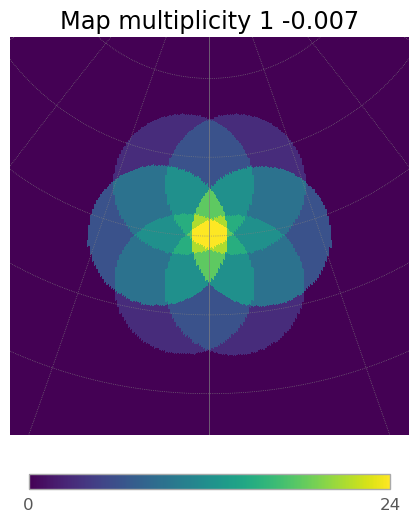

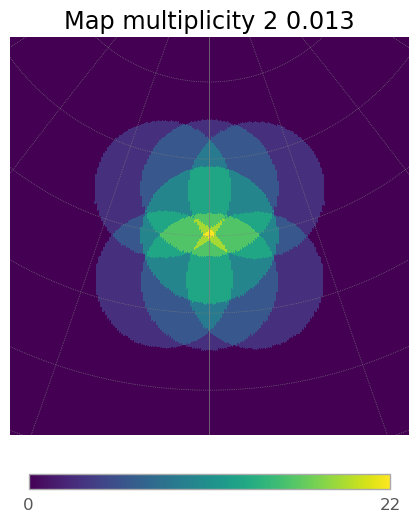

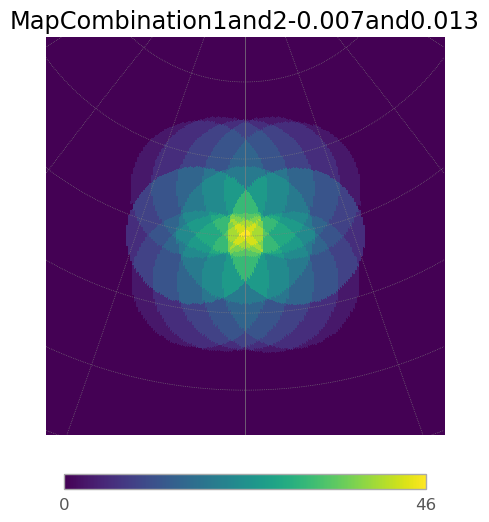

In [76]:
SST_config_conv.divergent_pointing_2_div(tel_group_2=SST_config_div, complete_array=full_array_config_SST, div1=-0.007, div2=0.013, az=0, alt=70)
SST_config_conv.multiplicity_plot_2_div(SST_config_div, subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half)






6it [00:01,  5.67it/s]
7it [00:01,  6.75it/s]
4it [00:00,  6.83it/s]
6it [00:01,  5.93it/s]


12.639706828454463


7it [00:01,  6.24it/s]
4it [00:00,  7.02it/s]


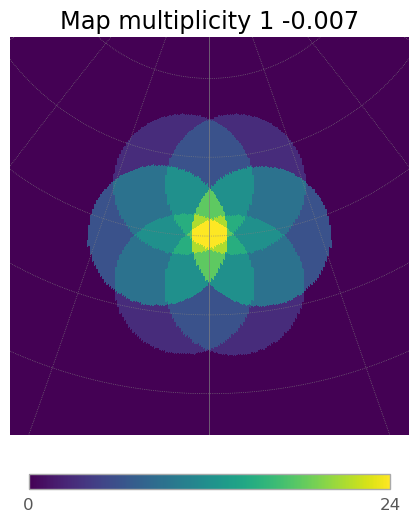

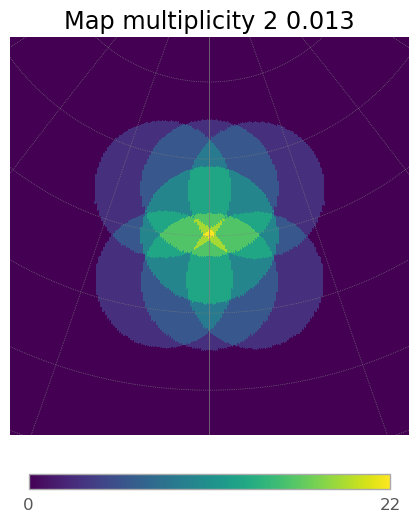

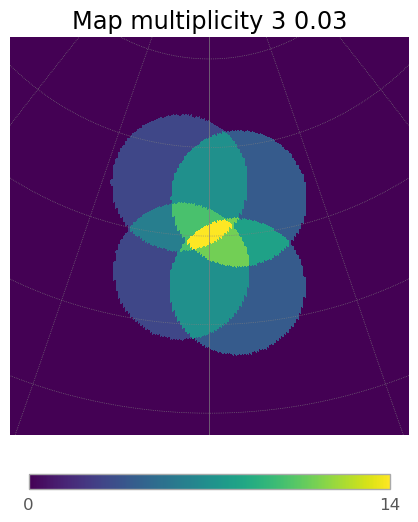

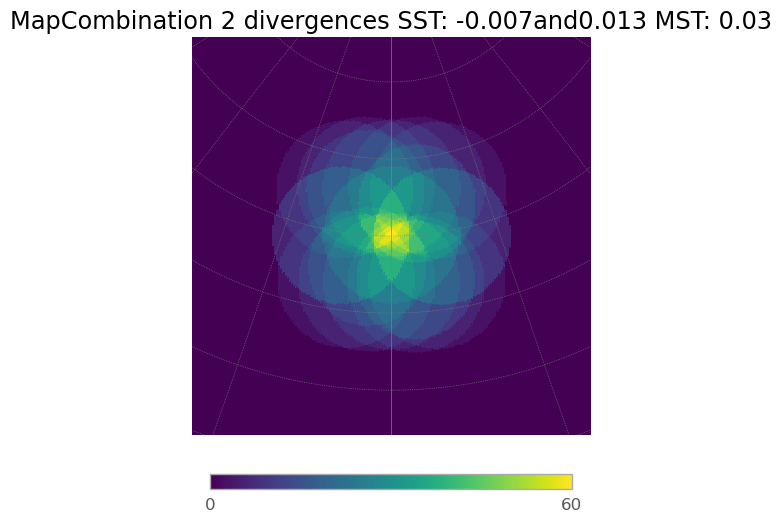

In [80]:
SST_config_conv.multiplicity_plot_3_config(array_2=SST_config_div,array_3=config_MST, subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3=number_of_telescopes_subarray_1)

## TO SEE THAT EVERYTHING IS OKAY MEANING THAT THE FOV OF THE MST IS SMALLER :)  SO THE PREVIOUS PART IS OKAY AS WELL

SST_config_conv.multiplicity_plot_2_div(config_MST)